In [2]:
from src import *

import warnings
warnings.filterwarnings("ignore")

## Description

We visualize joints plots fo 1st and 2nd eigenvectors of affinity matrices (i.e Gradients) and visualize their projection on cortical sufaces. 

GOAL: Joint plot 1st and 2nd connectivity gradients to visualize general topology and unimodal/transmodal distributions during rest and movie watching.

## Table of Contents
- [Single Video Processing](#single)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces
    - Per subject computing gradient (static gradient on 1 subject)


- [All Video Processing](#all)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces
    - Group level computing gradient (static gradient on all subjects (concatenated for now))
    - Loadings of affinity matrices

In [3]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [4]:
# We look at the same movie data but simply include subcortical in one of the sets
mri_path400 = "./data/fmri400_compiled/"
mri_path414 = "./data/fmri414_compiled/"

print(os.listdir(mri_path400))
print(os.listdir(mri_path414))

movie_name400   = 'AfterTheRain_compiled.csv'
mri_df400mov    = pd.read_csv(mri_path400 + movie_name400)
mri_df400rest   = pd.read_csv(mri_path400 + "Rest_compiled.csv")


movie_name414   = 'AfterTheRain_cortsubcort.csv'
mri_df414mov    = pd.read_csv(mri_path414 + movie_name414)
mri_df414rest   = pd.read_csv(mri_path414 + "Rest_cortsubcort.csv")

film_duration = FILM2DURATION[movie_name400.split('_')[0]] # in seconds
duration_film = int(film_duration/ TR) # in number of TRs
front_pad     = int(WASH + ONSET) + 1

['TheSecretNumber_compiled.csv', 'ToClaireFromSonny_compiled.csv', 'Chatter_compiled.csv', 'LessonLearned_compiled.csv', 'Payload_compiled.csv', 'AfterTheRain_compiled.csv', 'Superhero_compiled.csv', 'Sintel_compiled.csv', 'TearsOfSteel_compiled.csv', 'BetweenViewing_compiled.csv', 'BigBuckBunny_compiled.csv', 'Rest_compiled.csv', 'YouAgain_compiled.csv', 'Spaceman_compiled.csv', 'FirstBite_compiled.csv']
['Rest_cortsubcort.csv', 'AfterTheRain_cortsubcort.csv']


<a class="anchor" id="single"></a>
### Single Video Processing

#### Functional Connectivity Matrix and Gradient computation

In [4]:
rename = lambda x: 'TC_414_'+'_'.join(np.array(x.split('_'))[[2,4]])
mri_df414mov['filename']  = mri_df414mov['filename'].apply(rename)
mri_df414rest['filename'] = mri_df414rest['filename'].apply(rename)

In [5]:
mri_df414rest[mri_df414rest.partial_region=='Sub'].full_region.unique()

array(['Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum',
       'Left Hippocampus', 'Left Amygdala', 'Left Accumbens',
       'Right Thalamus', 'Right Caudate', 'Right Putamen',
       'Right Pallidum', 'Right Hippocampus', 'Right Amygdala',
       'Right Accumbens'], dtype=object)

In [6]:
filename_movie400 = mri_df400mov.filename.iloc[1000000]
filename_rest400  = mri_df400rest.filename.iloc[1000000]

filename_movie414 = mri_df414mov.filename.iloc[1000000]
filename_rest414  = mri_df414rest.filename.iloc[1000000]
print(filename_movie400)
print(filename_rest400)
print(filename_movie414)
print(filename_rest414)


movie_series400, _ = df_to_timeseries(mri_df400mov, filename_movie400)
movie_series400    = movie_series400[front_pad : front_pad + duration_film]
movie_series414, _ = df_to_timeseries(mri_df414mov, filename_movie414)
movie_series414    = movie_series414[front_pad : front_pad + duration_film]

rest_series400,  _ = df_to_timeseries(mri_df400rest, filename_rest400)
rest_series414,  _ = df_to_timeseries(mri_df414rest, filename_rest414)


fc_movie400 = FC(movie_series400)
fc_rest400  = FC(rest_series400)
fc_movie414 = FC(movie_series414)
fc_rest414  = FC(rest_series414)

TC_400_sub-S13_ses-1_AfterTheRain.csv
TC_400_sub-S04_ses-1_Rest.csv
TC_414_sub-S13_AfterTheRain.csv
TC_414_sub-S04_Rest.csv


In [7]:
g_rest400  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
g_rest400.fit(fc_rest400)

g_movie400 = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs, alignment=align_meth)
g_movie400.fit(fc_movie400, reference=g_rest400.gradients_)

print("Alignement score movies on rests': {}".format(procrustes_score(g_rest400.gradients_, g_movie400.aligned_)))

g_rest414  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
g_rest414.fit(fc_rest414)

g_movie414 = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs, alignment=align_meth)
g_movie414.fit(fc_movie414, reference=g_rest414.gradients_)

print("Alignement score movies on rests': {}".format(procrustes_score(g_rest414.gradients_, g_movie414.aligned_)))

Alignement score movies on rests': 160.8209321894014
Alignement score movies on rests': 149.3571547635512


#### Joint Plot of 1st and 2nd Gradient (2d plot)

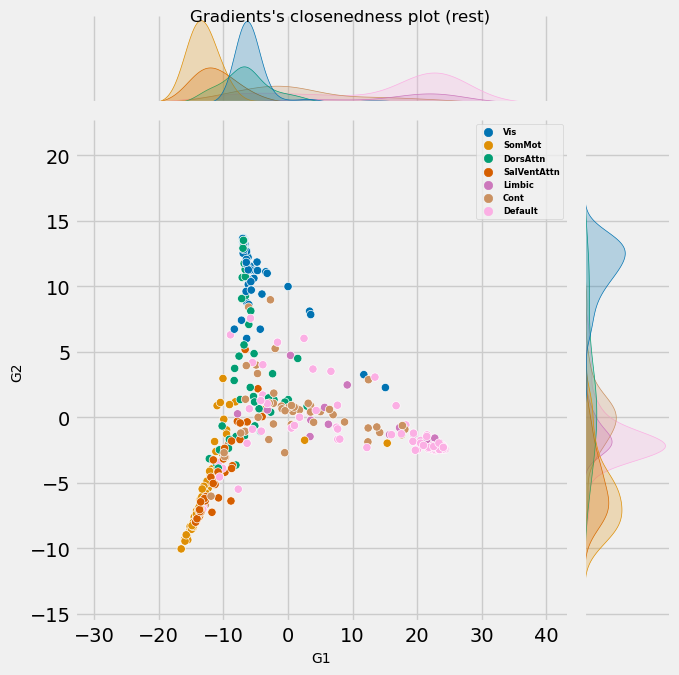

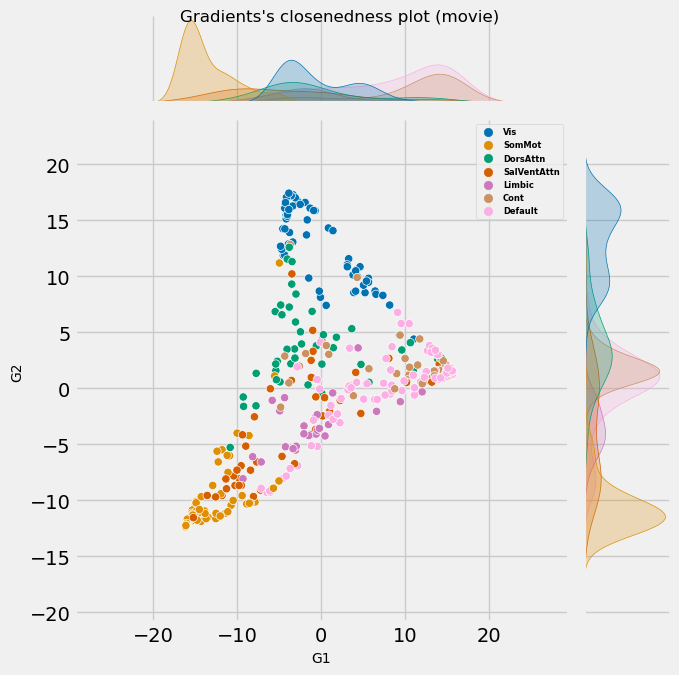

In [19]:
# 400 Parcellations
pal            = sns.color_palette('colorblind', 8)
partial_region = load('./resources/region400yeo7.pkl')
coloring       = [partial_region[i] for i in range(400)]

gs = [g_rest400, g_movie400]
ts = ['rest', 'movie']
for i in range(2):
    if i == 0:
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G2": gs[i].gradients_[:,1], "region": coloring}
    else:
        tmp_df = {"G1":gs[i].aligned_[:,0] , "G2": gs[i].aligned_[:,1], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue="region", height=7, palette=pal)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]), fontsize=12)
    legend_properties = {'weight':'bold','size':6}

    # ax.set_axis_labels('G1', 'G2', fontsize=10)

    ax.ax_joint.legend(prop=legend_properties,loc='upper right')
    ax.ax_joint.set_xlabel('G1',fontsize=10)
    ax.ax_joint.set_ylabel('G2',fontsize=10)

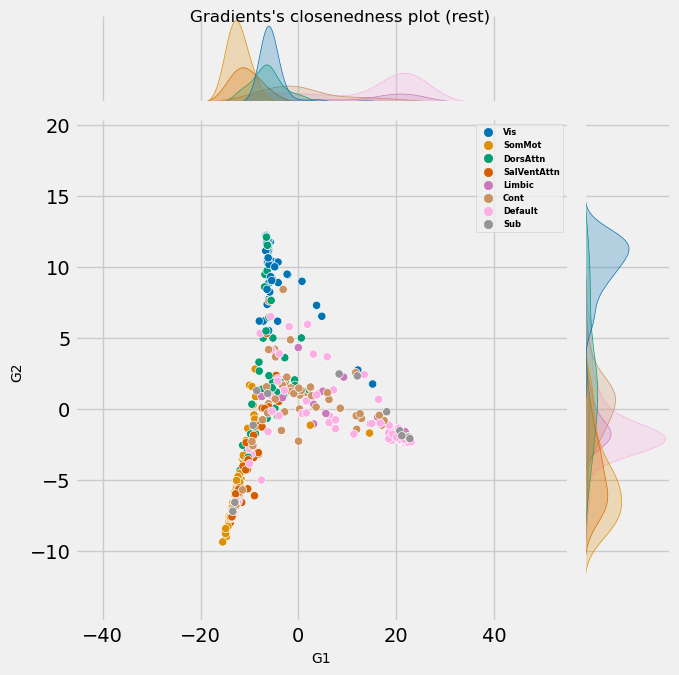

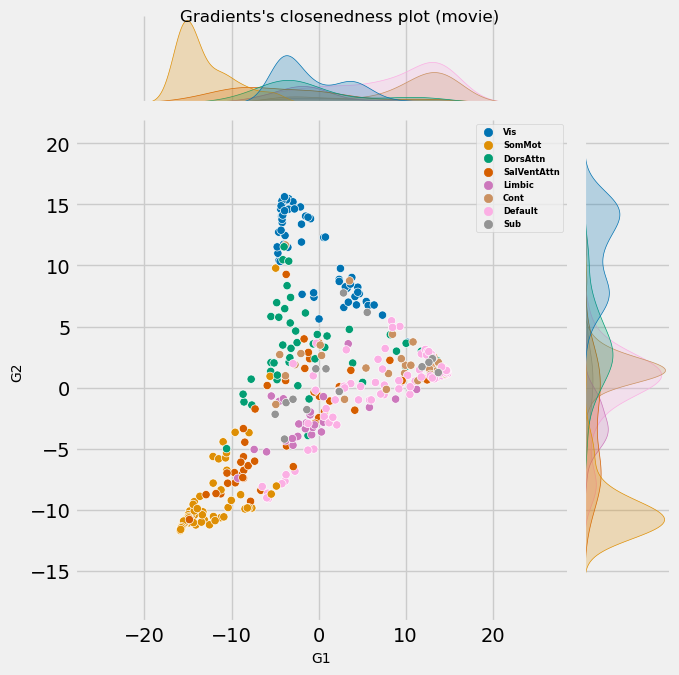

In [21]:
# 414 Parcellations
pal            = sns.color_palette('colorblind', 8)
partial_region = load('./resources/region414yeo7.pkl')
coloring       = [partial_region[i] for i in range(414)]

gs = [g_rest414, g_movie414]
ts = ['rest', 'movie']
for i in range(2):
    if i == 0:
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G2": gs[i].gradients_[:,1], "region": coloring}
    else:
        tmp_df = {"G1":gs[i].aligned_[:,0] , "G2": gs[i].aligned_[:,1], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue="region", height=7, palette=pal)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]), fontsize=12)
    legend_properties = {'weight':'bold','size':6}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')
    ax.ax_joint.set_xlabel('G1',fontsize=10)
    ax.ax_joint.set_ylabel('G2',fontsize=10)

#### Joint Plot of First 3 Gradients (3d plot)

In [39]:
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(pal)

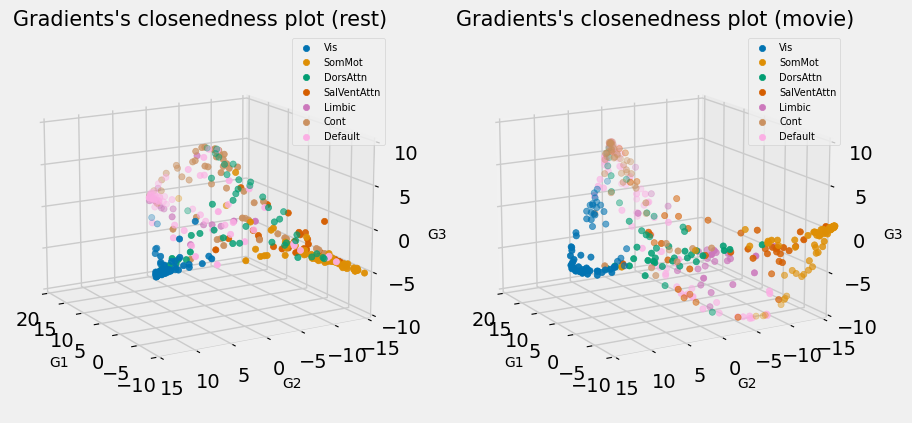

In [40]:
# 400 Parcellations
partial_region = load('./resources/yeo7region400.pkl')
fig = plt.figure(figsize=plt.figaspect(0.5))

grad_rest  = gs[0].gradients_
grad_movie = gs[1].aligned_
grads = [grad_rest, grad_movie]
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    for idx,net in enumerate(partial_region.keys()):
        s = partial_region[net]
        ax.scatter(grads[i][s,0],
                grads[i][s,1],
                grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx])
    ax.set_xlabel('G1', size=10)
    ax.set_ylabel('G2', size=10)
    ax.set_zlabel('G3', size=10)
    ax.legend(prop={'size':7})
    ax.set_title("Gradients's closenedness plot ({})".format(ts[i]), size=15)
    ax.view_init(15, 150)
    ax.set_xlim(-10,20)
    ax.set_ylim(-15,15)
    ax.set_zlim(-10,10)

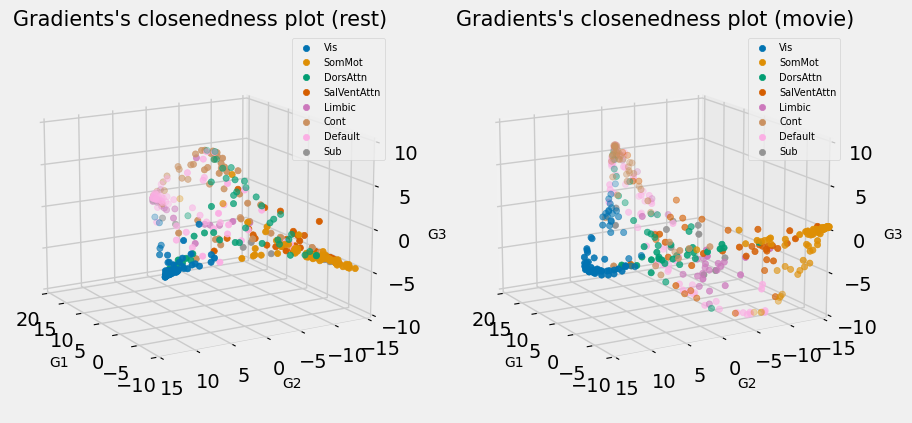

In [41]:
# 414 Parcellations
partial_region = load('./resources/yeo7region414.pkl')
fig = plt.figure(figsize=plt.figaspect(0.5))

gs = [g_rest414, g_movie414]
grad_rest  = gs[0].gradients_
grad_movie = gs[1].aligned_
grads = [grad_rest, grad_movie]
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    for idx,net in enumerate(partial_region.keys()):
        s = partial_region[net]
        ax.scatter(grads[i][s,0],
                grads[i][s,1],
                grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx])
    ax.set_xlabel('G1', size=10)
    ax.set_ylabel('G2', size=10)
    ax.set_zlabel('G3', size=10)
    ax.legend(prop={'size':7})
    ax.set_title("Gradients's closenedness plot ({})".format(ts[i]), size=15)
    ax.view_init(15, 150)
    ax.set_xlim(-10,20)
    ax.set_ylim(-15,15)
    ax.set_zlim(-10,10)

#### Visualization of Yeo-7 Parcellation on cortical surface
- We currently do the assumption that the labelling of cortical surfaces from `brainspace conte69` are of the same order as the one we currently 

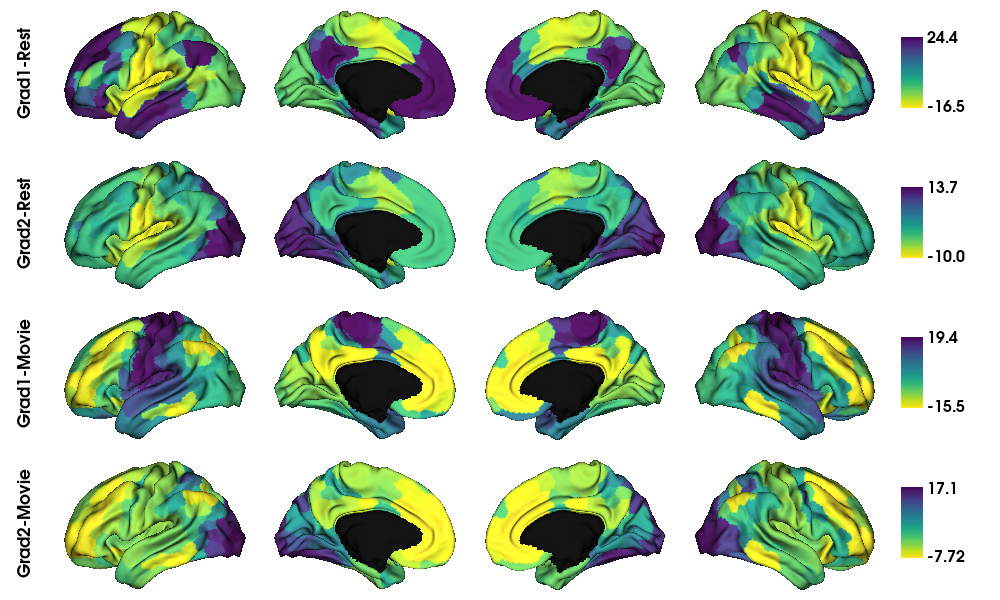

In [42]:
# Parcellation 400
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0
gs   = [g_rest400, g_movie400]
grad = [None] * 4
for i in range(2):
    for k in range(2):
        # map the gradient to the parcels
        grad[i*2+k] = map_to_labels(gs[i].gradients_[:, k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1-Rest', 'Grad2-Rest', 'Grad1-Movie', 'Grad2-Movie'], zoom=1.55, embed_nb=True, interactive=False,
                 transparent_bg=False)

#### Per subject computing gradient

In [44]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

front_pad  = int(WASH + ONSET) + 1

In [9]:
# This Generates individual Gradients for 400 parcellations
# Note: Simply replace by 414 to save gradients with 414 regions (do remember to change the output filenames however) 
for i in range(len(os.listdir(mri_path400))):
    movie_name   = os.listdir(mri_path400)[i]
    mri_df       = pd.read_csv(mri_path400 + movie_name)
    if "Rest" in movie_name:
        end = -1
    else:
        film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
        duration_film = int(film_duration/ TR) # in number of TRs
        end           = front_pad + duration_film

    subject_grad = {}
    acqui        = [k for k in mri_df.filename.unique() if '400' in k]
    for filename_movie in acqui:
        subject         = filename_movie.split('_')[2].split('-')[1]
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : end]

        fc = FC(movie_series)
        g  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        subject_grad[subject] = g.gradients_
    save('./resources/static_grad/individual_level/'+movie_name.split('_')[0]+'_grad.pkl',subject_grad)

<a class="anchor" id="all"></a>
### Multiple concatenated

#### Functional Connectivity Matrix and Gradient computation

In [5]:
# Simply replace 400 by 414 to look at spatial relation with subcortical regions included
movies = [m for m in mri_df400mov.filename.unique() if "400" in m]
rests  = [m for m in mri_df400rest.filename.unique() if "400" in m]

movie_series = []
rest_series  = []
for m in movies:
    tmp1, _ = df_to_timeseries(mri_df400mov, m)
    tmp1    = tmp1[front_pad :  front_pad + duration_film]
    movie_series.append(tmp1)
for r in rests:
    tmp2, _ = df_to_timeseries(mri_df400rest, r)
    rest_series.append(tmp2)

movies_series = np.concatenate(movie_series)
rests_series  = np.concatenate(rest_series)

In [46]:
fc_movies = FC(movies_series)
fc_rests  = FC(rests_series)

g_rests  = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_rests.fit(fc_rests)

# we fit movies' gradient onto rests'
g_movies = GradientMaps(n_components=nb_comp, approach=embedding, alignment=align_meth,
                        kernel=aff_kernel, random_state=rs)
g_movies.fit(fc_movies, reference=g_rests.gradients_)
print("Alignement score movies on rests': {}".format(procrustes_score(g_rests.gradients_, g_movies.aligned_)))

Alignement score movies on rests': 36.27656230583379


#### Joint Plot of 1st and 2nd Gradient + 1st and 3rd Gradient (2D)

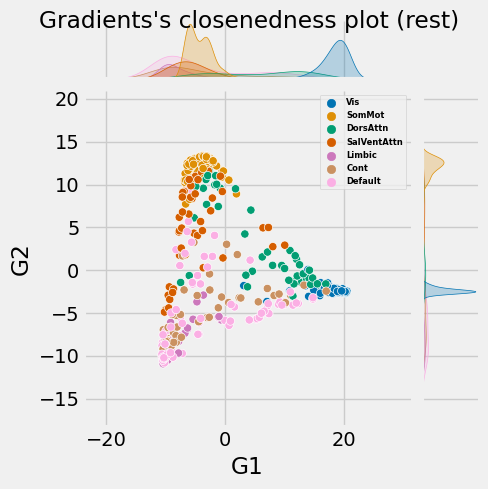

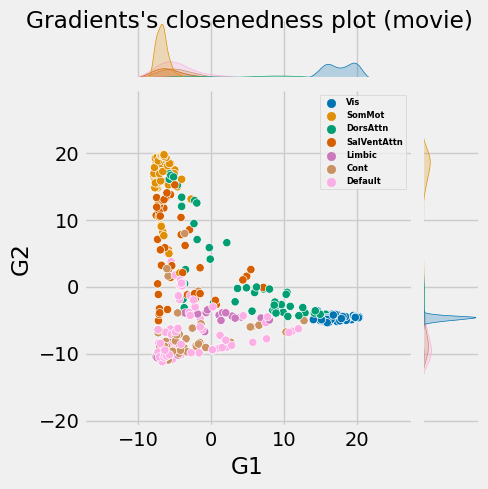

In [47]:
partial_region = load('./resources/region400yeo7.pkl')
coloring       = [partial_region[i] for i in range(400)]
pal            = sns.color_palette('colorblind', 8)

gs = [g_rests, g_movies]

ts = ['rest', 'movie']
for i in range(2):
    # we keep exact same coloring method: same encoding
    if i == 0:
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G2": gs[i].gradients_[:,1], "region": coloring}
    else:
        tmp_df = {"G1":gs[i].aligned_[:,0] , "G2": gs[i].aligned_[:,1], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G2", hue="region", height=5, palette=pal)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
    legend_properties = {'weight':'bold','size':6}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')


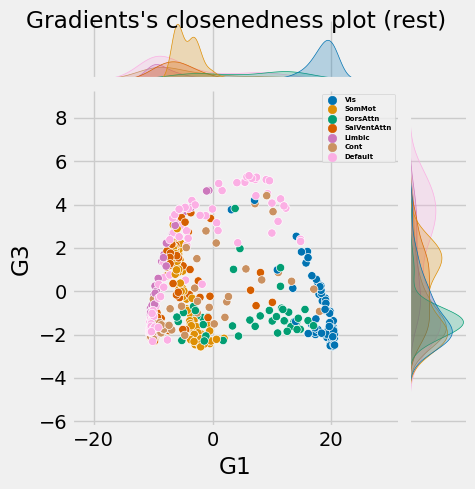

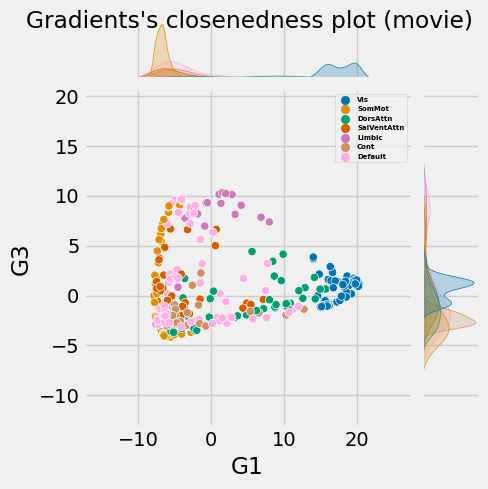

In [48]:
coloring  = [partial_region[i] for i in range(400)]
pal       = sns.color_palette('colorblind', 8)

gs = [g_rests, g_movies]

ts = ['rest', 'movie']
for i in range(2):
    # we keep exact same coloring method: same encoding
    if i == 0:
        tmp_df = {"G1":gs[i].gradients_[:,0] , "G3": gs[i].gradients_[:,2], "region": coloring}
    else:
        tmp_df = {"G1":gs[i].aligned_[:,0] , "G3": gs[i].aligned_[:,2], "region": coloring}
    ax     = sns.jointplot(data=tmp_df, x="G1", y="G3", hue="region", height=5, palette=pal)
    ax.fig.suptitle("Gradients's closenedness plot ({})".format(ts[i]))
    legend_properties = {'weight':'bold','size':5}
    ax.ax_joint.legend(prop=legend_properties,loc='upper right')


#### Joint Plot of First 3 gradients (3D)

In [ ]:
my_cmap = ListedColormap(pal)

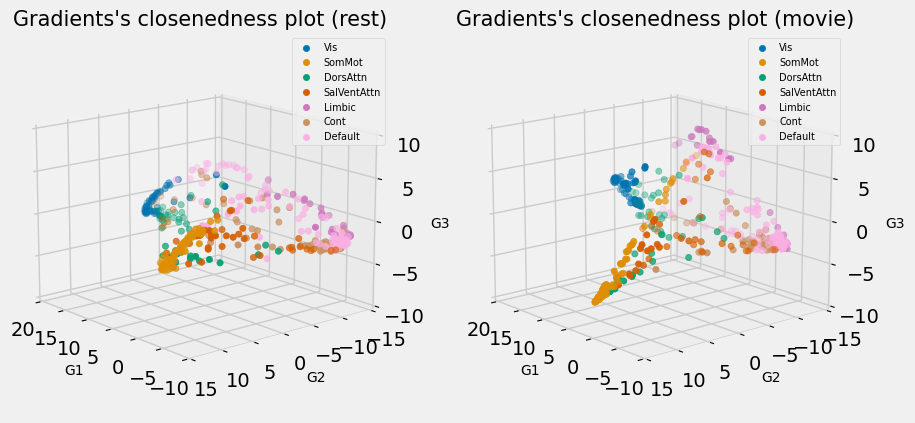

In [49]:
partial_region = load('./resources/yeo7region400.pkl')
fig = plt.figure(figsize=plt.figaspect(0.5))

grad_rest  = gs[0].gradients_
grad_movie = gs[1].aligned_
grads = [grad_rest, grad_movie]
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')


    for idx,net in enumerate(partial_region.keys()):
        s = partial_region[net]
        ax.scatter(grads[i][s,0],
                grads[i][s,1],
                grads[i][s,2], linewidth=0.5, label=net, color=my_cmap.colors[idx])
    ax.set_xlabel('G1', size=10)
    ax.set_ylabel('G2', size=10)
    ax.set_zlabel('G3', size=10)
    ax.legend(prop={'size':7})
    ax.set_title("Gradients's closenedness plot ({})".format(ts[i]), size=15)
    ax.view_init(15, 140)
    ax.set_xlim(-10,20)
    ax.set_ylim(-15,15)
    ax.set_zlim(-10,10)

#### Visualization of Yeo-7 Parcellation on cortical surface
- We currently do the assumption that the labelling of cortical surfaces from `brainspace conte69` are of the same order as the one we currently 

/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


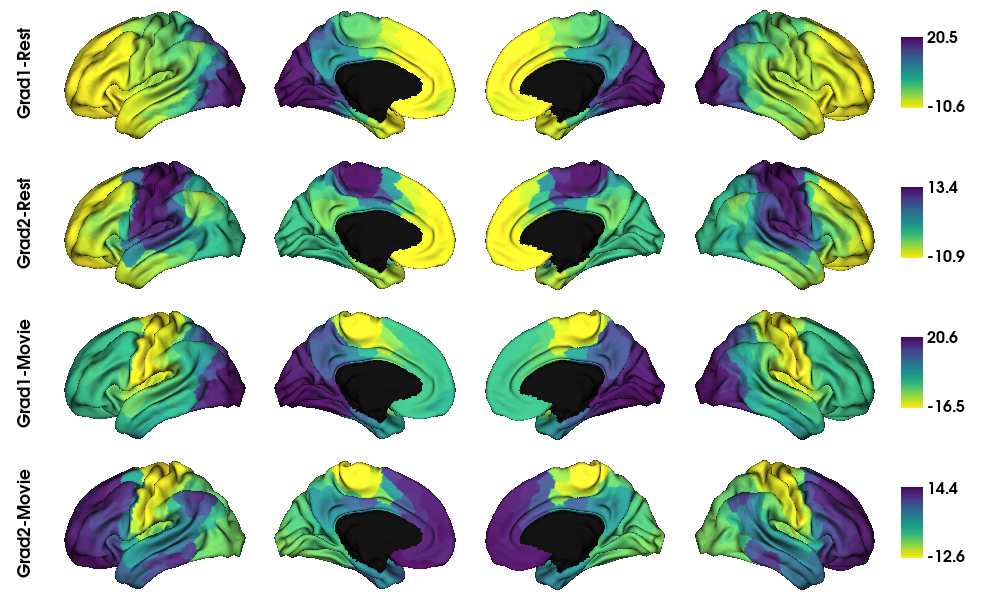

: 

In [31]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()


mask = labeling != 0
gs   = [g_rests, g_movies]
grad = [None] * 4
for i in range(2):
    for k in range(2):
        # map the gradient to the parcels
        grad[i*2+k] = map_to_labels(gs[i].gradients_[:, k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1-Rest', 'Grad2-Rest', 'Grad1-Movie', 'Grad2-Movie'], zoom=1.55, embed_nb=True, interactive=False,
                 transparent_bg=False)


#### Generating Group Level Static gradient (i.e 1 per movie)

In [50]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

# trim the washimg time for movies before and after
front_pad  = int(WASH + ONSET) + 1

In [ ]:
# This Generates group Gradients for 400 parcellations
# Note: Simply replace by 414 to save gradients with 414 regions (do remember to change the output filenames however) 

for i in range(len(os.listdir(mri_path400))):
    movie_name   = os.listdir(mri_path400)[i]
    mri_df       = pd.read_csv(mri_path400 + movie_name)
    if "Rest" in movie_name:
        end = -1
    else:
        film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
        duration_film = int(film_duration/ TR) # in number of TRs
        end           = front_pad + duration_film

    acqui        = [k for k in mri_df.filename.unique() if '400' in k]
    for filename_movie in acqui:
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : end]

    movies_series = np.concatenate(movie_series)
    fc = FC(movie_series)
    g  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc)
    save('./resources/static_grad/group_level/'+movie_name.split('_')[0]+'_grad.pkl',g.gradients_)

#### Generating Group Level Static gradient (i.e 1 per movie)

In [6]:
fc_movies = FC(movies_series)
fc_rests  = FC(rests_series)

g_rests  = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_rests.fit(fc_rests)

# we fit movies' gradient onto rests'
g_movies = GradientMaps(n_components=nb_comp, approach=embedding, alignment=align_meth,
                        kernel=aff_kernel, random_state=rs)
g_movies.fit(fc_movies, reference=g_rests.gradients_)
print("Alignement score movies on rests': {}".format(procrustes_score(g_rests.gradients_, g_movies.aligned_)))

Alignement score movies on rests': 36.27656230583379


In [13]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(fc_rests)

PCA()